In [1]:
%pip install mne xgboost tensorflow scikit-learn pandas numpy matplotlib scipy tqdm


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import mne
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, LSTM, GRU, SimpleRNN, 
    Input, MultiHeadAttention, LayerNormalization, 
    TimeDistributed, Flatten, Bidirectional
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_sleep_data(data_dir):                                              # Sleep-EDF icin veri setini yukluyoruz.
    file_pairs = []
    
    for f in os.listdir(data_dir):                                          # Dosya eslestirme islemi yapiyoruz.
        if f.endswith('0-PSG.edf'):
            hyp_file = f.replace('0-PSG.edf', 'C-Hypnogram.edf')
            if os.path.exists(os.path.join(data_dir, hyp_file)):            # Ayni konuya ait PSG ve Hypnogram dosyalarini eslestiriyoruz.
                file_pairs.append((                                         # PSG dosyasi sinyalleri tutar ve Hypnogram dosyasi labellari tutar.
                    os.path.join(data_dir, f),
                    os.path.join(data_dir, hyp_file)
                ))
    
    print(f"Bulunan PSG-Hypnogram çiftleri: {len(file_pairs)}")
    return file_pairs

In [4]:
from scipy.signal import find_peaks, welch
from scipy.stats import entropy, kurtosis, skew, iqr

def bandpower(psd, freqs, fmin, fmax):
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.sum(psd[idx_band])

def extract_features_multi(data, sfreq, n_fft_comp=5):
    feature_list = []
    count = 0
    
    # Zaman serisinde ozellik cikarimi yapiyorum. Buradaki ozniteliklerin cogunu TSFEL: Time Series Feature Extraction Library makalesinden aldim.

    for epoch in data:
        feats = []
        for ch_signal in epoch:
            t = np.arange(len(ch_signal))
            abs_energy = np.sum(ch_signal**2)                                                           # Sinyalin toplam enerjisi, guc olcusu
            area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri
            
            autocorr = np.corrcoef(ch_signal[:-1], ch_signal[1:])[0, 1] if np.std(ch_signal) > 0 else 0 # Sinyalin kendisiyle bir gecikmeyle olan korelasyonu
            
            avg_power = np.mean(ch_signal**2)                                                           # Ortalama guc
            centroid = np.sum(t * np.abs(ch_signal)) / (np.sum(np.abs(ch_signal)) + 1e-12)              # Sinyal agirlik merkezi
            
            hist, _ = np.histogram(ch_signal, bins=10, density=True)
            hist_entropy = entropy(hist + 1e-12)                                                        # Sinyal genlik dagiliminin duzensizligi
            
            freqs, psd = welch(ch_signal, sfreq, nperseg=min(256, len(ch_signal)))
            psd /= np.sum(psd) + 1e-12                                                                  # Frekanslara gore enerji dagilimi
            
            fund_freq = freqs[np.argmax(psd)] if len(psd) > 0 else 0                                    # En yuksek guce sahip frekans bileşeni
            
            hist_vals, hist_bins = np.histogram(ch_signal, bins=10)
            hist_mode = hist_bins[np.argmax(hist_vals)]                                                 # En cok gorulen genlik degeri
            
            human_energy = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])                                  # Insan EEG bandindaki enerji
            iqr_val = iqr(ch_signal)                                                                    # Sinyalin orta %50'sinin yayilimi
            kurt_val = kurtosis(ch_signal)                                                              # Carpiklik, uc deger yogunlugu
            
            max_val = np.max(ch_signal)                                                                 # Maksimum deger
            max_psd = np.max(psd)                                                                       # Maksimum guc
            max_freq = freqs[-1]                                                                        # En yuksek olculebilir frekans
            
            mean_val = np.mean(ch_signal)                                                               # Ortalama deger
            mad = np.mean(np.abs(ch_signal - mean_val))                                                 # Ortalama mutlak sapma
            mean_abs_diff = np.mean(np.abs(np.diff(ch_signal)))                                         # Komşu ornekler arasindaki ortalama mutlak fark
            mean_diff = np.mean(np.diff(ch_signal))                                                     # Komşu ornekler arasindaki ortalama fark
            
            med_val = np.median(ch_signal)                                                              # Medyan deger
            med_abs_dev = np.median(np.abs(ch_signal - med_val))                                        # Medyan mutlak sapma
            med_abs_diff = np.median(np.abs(np.diff(ch_signal)))                                        # Medyan komşu mutlak farki
            med_diff = np.median(np.diff(ch_signal))                                                    # Medyan komşu farki
            cumulative_power = np.cumsum(psd)
            med_freq = freqs[np.argmax(cumulative_power >= 0.5)] if len(psd) > 0 else 0                 # Medyan frekans
            
            min_val = np.min(ch_signal)                                                                 # Minimum deger
            
            diff_signal = np.diff(ch_signal)
            sign_changes = np.diff(np.sign(diff_signal))
            neg_turning = np.sum(sign_changes > 0)                                                      # Negatif egimden pozitif egime geciş sayisi
            pos_turning = np.sum(sign_changes < 0)                                                      # Pozitif egimden negatif egime geciş sayisi
            peaks, _ = find_peaks(ch_signal)
            n_peaks = len(peaks)                                                                        # Tepe sayisi
            peak_dist = np.mean(np.diff(peaks)) if n_peaks > 1 else 0                                   # Tepeler arasi ortalama mesafe
            
            if len(psd) > 0:
                peak_psd = np.max(psd)
                mask = psd >= (peak_psd / 2)
                try:
                    power_bandwidth = freqs[mask][-1] - freqs[mask][0]                                  # Gucun %50'sinden fazlasini iceren frekans araligi
                except:
                    power_bandwidth = 0
            else:
                power_bandwidth = 0
                
            rms = np.sqrt(avg_power)                                                                    
            signal_dist = np.sum(np.abs(ch_signal))                                                     # Mutlak genlik toplami
            skew_val = skew(ch_signal)                                                                  # Simetri olcusu
            slope = np.polyfit(t, ch_signal, 1)[0]                                                      # Lineer egim, trend
            
            spec_centroid = np.sum(freqs * psd) / (np.sum(psd) + 1e-12)                                 # Spektral agirlik merkezi
            spec_decrease = np.sum((psd[1:] - psd[0]) / np.arange(1, len(psd))) / (np.sum(psd[1:]) + 1e-12) if len(psd) > 1 else 0   # Yuksek frekanslardaki guc kaybi
            spec_ent = entropy(psd + 1e-12)                                                             # Spektral entropi
            spec_kurt = kurtosis(psd)                                                                   # Spektral carpiklik
            diff_psd = np.diff(psd)
            psd_sign_changes = np.diff(np.sign(diff_psd))
            spec_pos_turning = np.sum(psd_sign_changes < 0)                                             # Spektral donuş noktasi sayisi
            spec_roll_off = freqs[np.argmax(cumulative_power >= 0.85)] if len(psd) > 0 else 0           # Enerjinin %85'ine ulaşilan frekans
            spec_roll_on = freqs[np.argmax(cumulative_power >= 0.05)] if len(psd) > 0 else 0            # Enerjinin %5'ine ulaşilan frekans
            spec_skew = skew(psd)                                                                       # Spektral skewness
            spec_slope = np.polyfit(freqs, psd, 1)[0] if len(psd) > 1 else 0                            # Spektral egim
            spec_spread = np.sqrt(np.sum(psd * (freqs - spec_centroid)**2) / (np.sum(psd) + 1e-12))     # Spektral yayilma
            
            std = np.std(ch_signal)                                                                     # Standart sapma
            sum_abs_diff = np.sum(np.abs(np.diff(ch_signal)))                                           # Ornekler arasi toplam fark
            var = np.var(ch_signal)                                                                     # Varyans
            
            zero_crossings = np.sum(np.diff(np.sign(ch_signal)) != 0)
            zcr = zero_crossings / len(ch_signal)                                                       # Sinyalin kac kez sifiri gectigi

            bp_delta = bandpower(psd, freqs, 0.5, 4)                                                    # Bant güçleri (delta: 0.5–4Hz, theta: 4–8Hz, alpha: 8–13Hz, beta: 13–30Hz, gamma: 30–40Hz)
            bp_theta = bandpower(psd, freqs, 4, 8)
            bp_alpha = bandpower(psd, freqs, 8, 13)
            bp_beta  = bandpower(psd, freqs, 13, 30)
            bp_gamma = bandpower(psd, freqs, 30, 40)
            
            fft_vals = np.fft.rfft(ch_signal)                                                           # FFT bileşenleri (en büyük n_fft_comp genlik)
            fft_power = np.abs(fft_vals)
            top_fft_indices = np.argsort(fft_power)[-n_fft_comp:][::-1]
            top_fft_components = fft_power[top_fft_indices]

            features = [
                abs_energy, area_curve, autocorr, avg_power, centroid, hist_entropy,
                fund_freq, hist_mode, human_energy, iqr_val, kurt_val, max_val,
                bp_delta, bp_theta, bp_alpha, bp_beta, bp_gamma, *top_fft_components,
                max_psd, max_freq, mean_val, mad, mean_abs_diff, mean_diff, med_val,
                med_abs_dev, med_abs_diff, med_diff, med_freq, min_val, neg_turning,
                n_peaks, peak_dist, pos_turning, power_bandwidth, rms, signal_dist,
                skew_val, slope, spec_centroid, spec_decrease, spec_ent,
                spec_kurt, spec_pos_turning, spec_roll_off, spec_roll_on, spec_skew,
                spec_slope, spec_spread, std, sum_abs_diff, var, zcr
            ]
            
            feats.extend(features)
            
        feature_list.append(feats)
        count += 1
        
    print(f"Özellik çıkarımı için toplam {count} epoch işlendi.")
    return np.array(feature_list)

In [5]:
def create_sequences(data, labels, seq_length=10):                                                      # Zaman serisi verileri olusturuyorum.
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length-1])
    return np.array(X), np.array(y)

def create_dataset(file_pairs, epoch_duration=45.0, seq_length=10):
    base_event_id = {
        'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2,
        'Sleep stage 3': 3, 'Sleep stage 4': 3, 'Sleep stage R': 4
    }
    all_sequences = []
    all_labels = []
    
    for psg_file, hyp_file in file_pairs:                                                               # Her PSG-Hypnogram dosya cifti icin yukleme dongusu
        raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
        annots = mne.read_annotations(hyp_file)
        raw.set_annotations(annots, emit_warning=False)

        descs = set([str(d) for d in annots.description])                                               # O anda bulunan descriptionlari aliyorum.
        event_id = {k: v for k, v in base_event_id.items() if k in descs}                               # Sadece dosyada olanları event_id'ye aliyorum.
        if len(event_id) == 0:
            continue

        events, _ = mne.events_from_annotations(                                                        # Anotasyonlardan epoch eventlerini olusturuyorum.
            raw, event_id=event_id, chunk_duration=epoch_duration
        )
        if len(events) == 0:
            continue

        epochs = mne.Epochs(
            raw, events, event_id=event_id,
            tmin=0.0, tmax=epoch_duration - 1/raw.info['sfreq'],                                        # Her epochun sonu 
            baseline=None, preload=True
        )
        data = epochs.get_data()
        feats = extract_features_multi(data, raw.info['sfreq'])                                         # Her epoch icin ozellik cikariyorum ve ozellikleri ve etiketleri listeye ekliyorum.
        labels = epochs.events[:, -1]
        

        sequences, seq_labels = create_sequences(feats, labels, seq_length)                             # Zaman serisi olusturuyorum.
        if len(sequences) > 0:
            all_sequences.append(sequences)
            all_labels.append(seq_labels)
    
    X = np.vstack(all_sequences)                                                                        # Tum dosyalarin ozelliklerini ve etiketlerini birlestiriyorum.
    y = np.hstack(all_labels)
    return X, y

In [6]:
def evaluate_model(y_true, y_pred, name):                                           # Temel metrikleri hesapliyorum
    acc = accuracy_score(y_true, y_pred)                                            # Isabet
    f1 = f1_score(y_true, y_pred, average='macro')                                  # f1 skoru
    kappa = cohen_kappa_score(y_true, y_pred)                                       # Cohen Kappa skoru
        
    print(f"\n{name} Performans:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("Sınıflandırma Raporu:")
    print(classification_report(y_true, y_pred,target_names=['Wake', 'N1', 'N2', 'N3', 'REM']))
        
    cm = confusion_matrix(y_true, y_pred)                                           # Confusion matrix gosteriyorum.
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Wake', 'N1', 'N2', 'N3', 'REM'])
    plt.yticks(tick_marks, ['Wake', 'N1', 'N2', 'N3', 'REM'])
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.show()
        
    return acc, f1, kappa

def build_rnn_model(input_shape, rnn_type='lstm', units=128):
    model = Sequential()
    
    if rnn_type == 'lstm':                                                                              # LSTM (uzun sureli bagimliliklari ogrenmede basarili)
        model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape))
        model.add(Bidirectional(LSTM(units)))   
    elif rnn_type == 'gru':                                                                             # GRU (daha hafif, daha hizli)
        model.add(Bidirectional(GRU(units, return_sequences=True), input_shape=input_shape))
        model.add(Bidirectional(GRU(units)))
    else:                                                                                               # Basit RNN
        model.add(Bidirectional(SimpleRNN(units, return_sequences=True), input_shape=input_shape))
        model.add(Bidirectional(SimpleRNN(units)))
    
    model.add(Dense(64, activation='relu'))                                                             # Tam baglantili gizli katman, dropout katmani, cikis katmani tanimliyorum.
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',                                                         # Siniflandirma icin kayip fonksiyonu
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)               # Dogrulama kaybi duzelmezse durduruyorum.
    
    history = model.fit(
        X_train, y_train,
        epochs=50,                                                                                      # Maksimum epoch sayisi
        batch_size=64,                                                                                  # Mini-batch boyutu
        validation_split=0.2,                                                                           # %20 validation boyutu
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = np.argmax(model.predict(X_test), axis=1)                                                   # Tahmin etme asamasi.
    metrics = evaluate_model(y_test, y_pred, model_name)                                                # Performans metirklerini elde ediyorum.
    
    plt.figure(figsize=(12, 4))                                                                         # Egitim adimlarini gorsellestiriyorum.
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model, metrics

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):                                       # Transformer modelini tanimlamayla ilgili kismi ChatGPT'den aldim.
    x = MultiHeadAttention(                                                                                     # Girdinin her zaman adiminin, diger tum adimlarla olan bagini ogrenmesini saglar.
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)                                                                                     # Overfitting'i azaltmak icin
    res = x + inputs                                                                                            # Girdiyi cikisa ekler, bu aglarin daha kolay ogrenmesini saglar, gradyan kaybi sorununu azaltir.                              


    x = LayerNormalization(epsilon=1e-6)(res)                                                                   # Normalizasyon katmani                                                                  
    x = Dense(ff_dim, activation="relu")(x)                                                                     # Gizli katman
    x = Dropout(dropout)(x)                                                                                     # Dropout asiri ogrenmeyi azaltir.
    x = Dense(inputs.shape[-1])(x)                                                                              # Giris boyutuna geri projeksiyon yapar.
    return x + res

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=256, num_layers=2, dropout=0.2):
    inputs = Input(shape=input_shape)                                                                           # Giris katmani
    x = inputs
    
    for _ in range(num_layers):                                                                                 # Belirtilen sayida transformer encoder blogu kullanir.
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = Flatten()(x)                                                                                            # Vektor haline getiriyorum.
    x = Dropout(dropout)(x)
    outputs = Dense(5, activation="softmax")(x)                                                                 # Cikis katmani
    
    model = Model(inputs, outputs)                                                                              # Modeli olusturuyorum.
    model.compile(
        loss="sparse_categorical_crossentropy",                                                                 # Siniflandirma icin kayip fonksiyonu
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model


Bulunan PSG-Hypnogram çiftleri: 10
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 4500 original time points ...
0 bad epochs dropped
Özellik çıkarımı için toplam 1691 epoch işlendi.
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1820 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1820 events and 4500 original time points ...
0 bad epochs dropped
Özellik çıkarımı için toplam 1820 epoch işlendi.
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep 

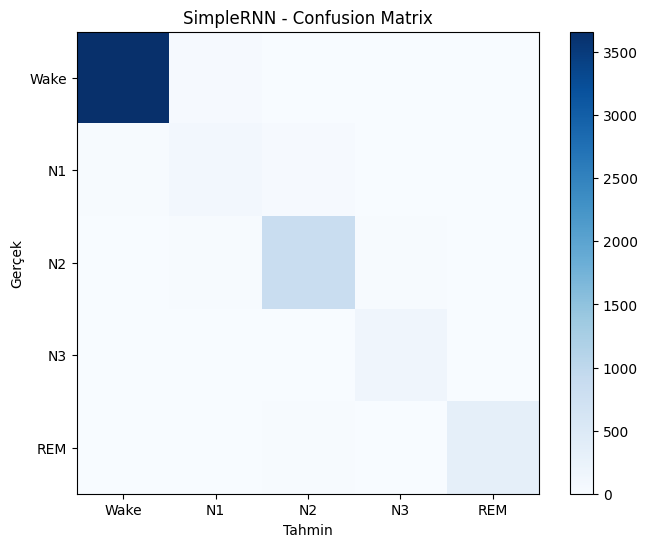

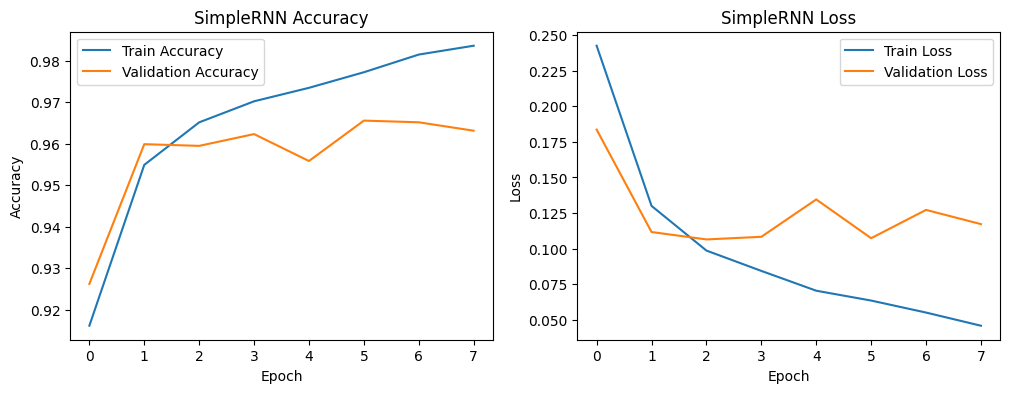


LSTM Model Eğitimi:
Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8894 - loss: 0.3447 - val_accuracy: 0.9457 - val_loss: 0.1407
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9586 - loss: 0.1200 - val_accuracy: 0.9501 - val_loss: 0.1145
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9630 - loss: 0.1004 - val_accuracy: 0.9643 - val_loss: 0.1002
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9718 - loss: 0.0783 - val_accuracy: 0.9627 - val_loss: 0.1006
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9729 - loss: 0.0725 - val_accuracy: 0.9639 - val_loss: 0.0975
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9798 - loss: 0.0575 - val_accuracy: 0.9623 - val_loss: 0.1090
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9751 - loss: 0.0630 - val_accuracy: 0.9651 - val_loss: 0.1096
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9784 - lo

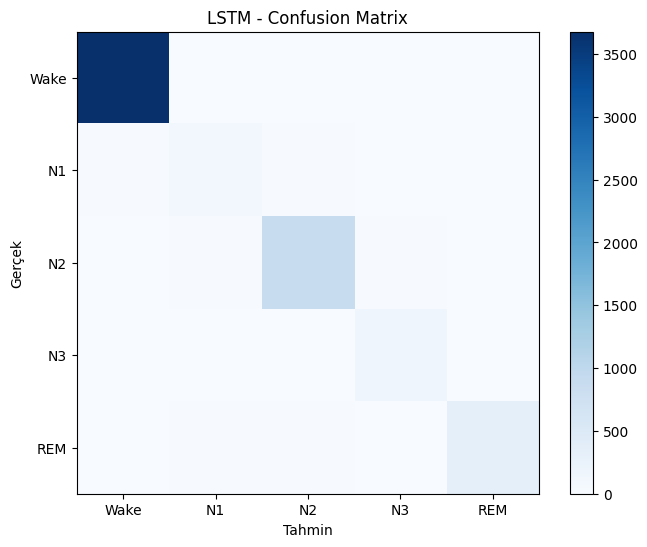

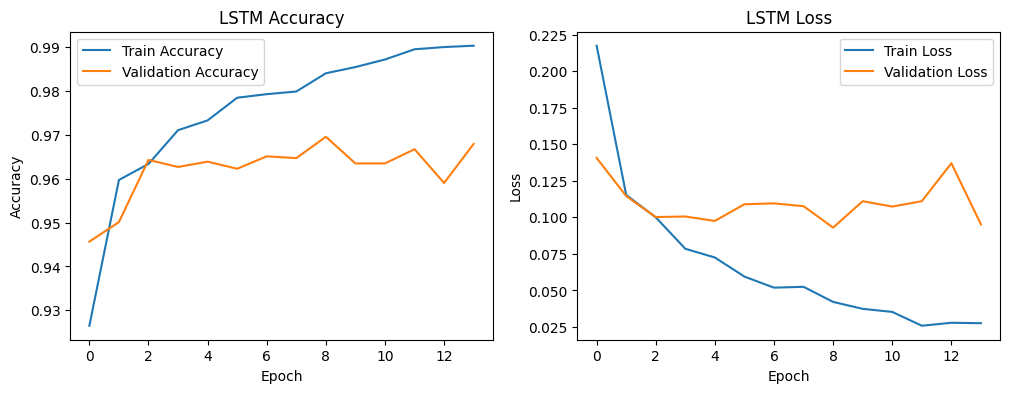


GRU Model Eğitimi:
Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8784 - loss: 0.3484 - val_accuracy: 0.9558 - val_loss: 0.1123
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9603 - loss: 0.1160 - val_accuracy: 0.9517 - val_loss: 0.1271
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9677 - loss: 0.0938 - val_accuracy: 0.9643 - val_loss: 0.0993
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9748 - loss: 0.0654 - val_accuracy: 0.9619 - val_loss: 0.1068
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9744 - loss: 0.0689 - val_accuracy: 0.9590 - val_loss: 0.0964
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9810 - loss: 0.0514 - val_accuracy: 0.9623 - val_loss: 0.1082
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9777 - loss: 0.0578 - val_accuracy: 0.9667 - val_loss: 0.0994
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9898 - los

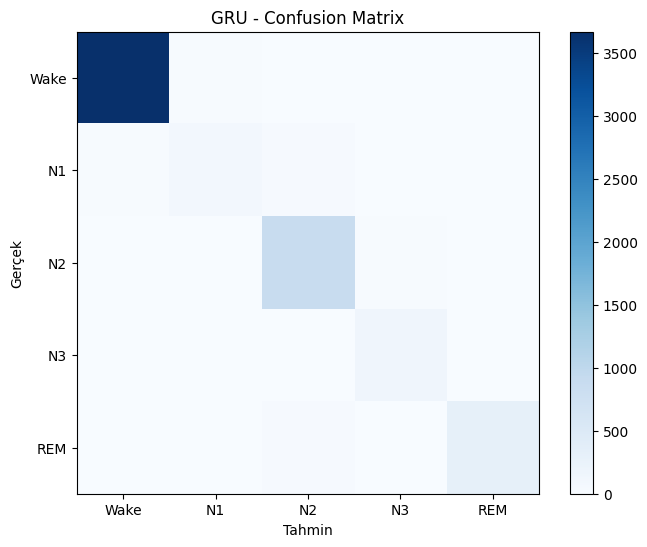

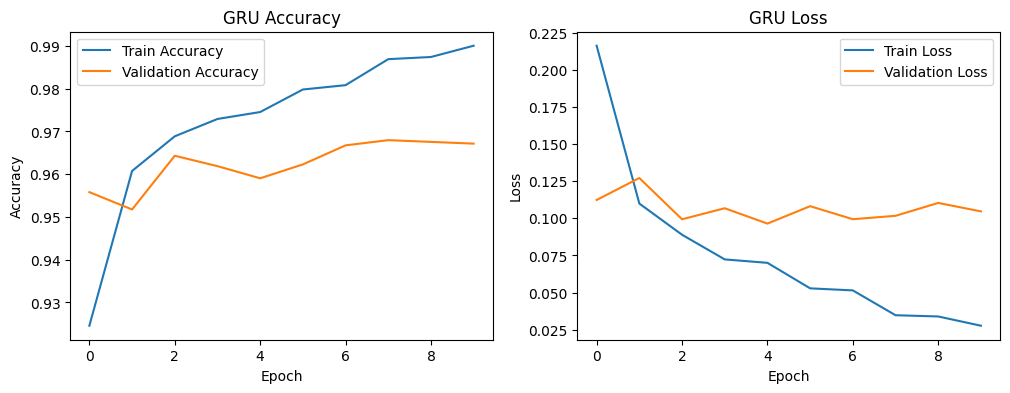


Transformer Model Eğitimi:
Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8765 - loss: 0.5194 - val_accuracy: 0.9517 - val_loss: 0.1632
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9453 - loss: 0.1670 - val_accuracy: 0.9440 - val_loss: 0.1773
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9567 - loss: 0.1464 - val_accuracy: 0.9542 - val_loss: 0.1623
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9600 - loss: 0.1279 - val_accuracy: 0.9534 - val_loss: 0.1664
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9584 - loss: 0.1251 - val_accuracy: 0.9319 - val_loss: 0.2494
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9617 - loss: 0.1207 - val_accuracy: 0.9489 - val_loss: 0.2600
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9356 - loss: 0.2949 - val_accuracy: 0.9542 - val_loss: 0.2231
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9

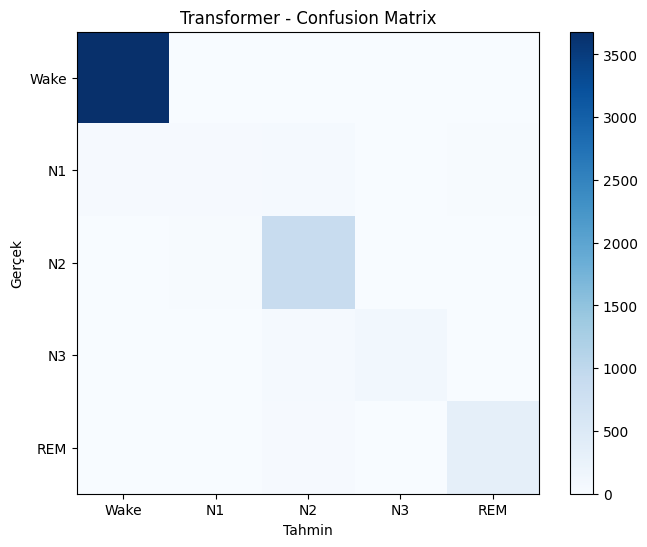

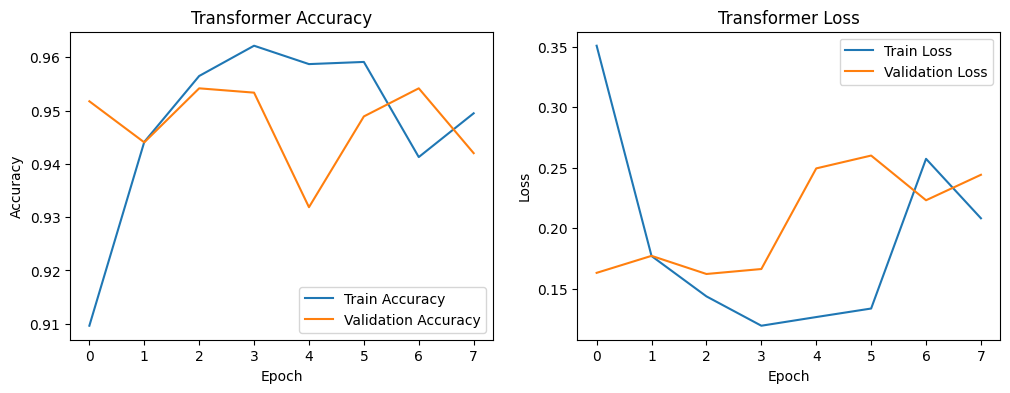


MODEL PERFORMANS KARŞILAŞTIRMASI:
RNN: Accuracy=0.9602, F1=0.8632, Kappa=0.9164
LSTM: Accuracy=0.9695, F1=0.8896, Kappa=0.9357
GRU: Accuracy=0.9637, F1=0.8696, Kappa=0.9232
Transformer: Accuracy=0.9512, F1=0.7872, Kappa=0.8958


In [7]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
def main():
    DATA_DIR = "./SleepData/Sleep_EDF_Training_Data"
    file_pairs = load_sleep_data(DATA_DIR)
    
    SEQ_LENGTH = 10                                                                                     # Zaman serisi uzunluğunu belirliyorum.
    
    X, y = create_dataset(file_pairs, epoch_duration=45.0, seq_length=SEQ_LENGTH)
    print("X shape:", X.shape, "y shape:", y.shape)
    
    n_samples, seq_len, n_features = X.shape                                                            # Veriyi ölçeklendiriyorum, daha onceden kullandigim kendi scalerim burada iyi calismadi.
    X_flat = X.reshape(-1, n_features)
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X_flat)
    X_scaled = X_flat_scaled.reshape(n_samples, seq_len, n_features)
    
    X_collapsed = np.mean(X_scaled, axis=1)
    selector = SelectKBest(f_classif, k=175)                                                            # En onemli ozellikleri seciyorum.
    selector.fit(X_collapsed, y)
    selected_indices = selector.get_support(indices=True)

    X_selected = X_scaled[:, :, selected_indices]
    print(f"Özellik seçimi sonrası boyut: {X_selected.shape}")

    X_train, X_test, y_train, y_test = train_test_split(                                                # Egitim ve test verisini ayiriyoruz.
        X_selected, y, test_size=0.3, random_state=42, stratify=y
    )
    
    input_shape = (SEQ_LENGTH, X_selected.shape[2])                                                     # Modelleri tanimliyoruz ve egitiyoruz.
    
    print("\nRNN Model Eğitimi:")
    rnn_model = build_rnn_model(input_shape, rnn_type='SimpleRNN', units=128)
    _, rnn_metrics = train_and_evaluate(rnn_model, X_train, y_train, X_test, y_test, "SimpleRNN")

    print("\nLSTM Model Eğitimi:")
    lstm_model = build_rnn_model(input_shape, rnn_type='lstm', units=128)
    _, lstm_metrics = train_and_evaluate(lstm_model, X_train, y_train, X_test, y_test, "LSTM")
    
    print("\nGRU Model Eğitimi:")
    gru_model = build_rnn_model(input_shape, rnn_type='gru', units=128)
    _, gru_metrics = train_and_evaluate(gru_model, X_train, y_train, X_test, y_test, "GRU")
    
    print("\nTransformer Model Eğitimi:")
    transformer_model = build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=256)
    _, transformer_metrics = train_and_evaluate(transformer_model, X_train, y_train, X_test, y_test, "Transformer")

    print("\nMODEL PERFORMANS KARŞILAŞTIRMASI:")                                                        # Toplu performans karsilastirmasi yapiyoruz.
    print(f"RNN: Accuracy={rnn_metrics[0]:.4f}, F1={rnn_metrics[1]:.4f}, Kappa={rnn_metrics[2]:.4f}")
    print(f"LSTM: Accuracy={lstm_metrics[0]:.4f}, F1={lstm_metrics[1]:.4f}, Kappa={lstm_metrics[2]:.4f}")
    print(f"GRU: Accuracy={gru_metrics[0]:.4f}, F1={gru_metrics[1]:.4f}, Kappa={gru_metrics[2]:.4f}")
    print(f"Transformer: Accuracy={transformer_metrics[0]:.4f}, F1={transformer_metrics[1]:.4f}, Kappa={transformer_metrics[2]:.4f}")

    lstm_model.save('lstm_model.h5')                                                                    # Egittigimiz modelleri kaydediyoruz.
    rnn_model.save('rnn_model.h5') 
    gru_model.save('gru_model.h5')
    transformer_model.save('transformer_model.keras')
    joblib.dump(scaler, 'scaler.joblib')
    joblib.dump(selector, 'selector.joblib')
    joblib.dump(selected_indices, 'selected_indices.joblib')
    
if __name__ == "__main__":
    main()

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 4500 original time points ...
0 bad epochs dropped
Özellik çıkarımı için toplam 1691 epoch işlendi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step

PSG file: SC4001E0-PSG.edf
Gerçek Etiket: 0 | Tahmin: 0


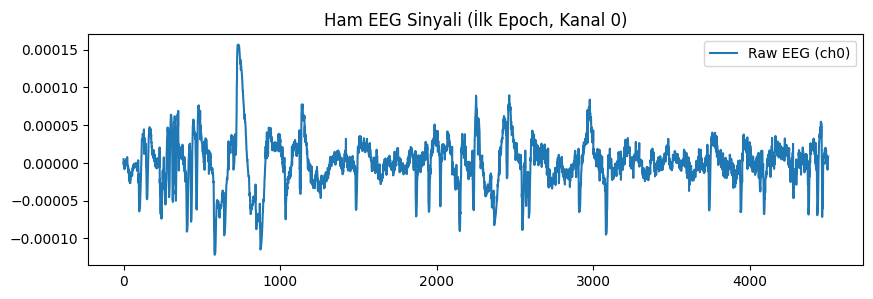

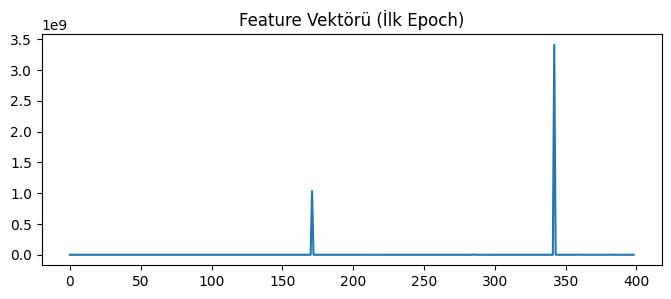

In [8]:
# Bu kisim egitimden bagimsiz, piazzada belirttiginiz sekilde tek veri ozelinde tahmin yapmamizi sagliyor.
def predict_and_show(psg_path, hyp_path, model, scaler,selector, selected_indices, seq_length=10, show_plot=True):
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)                            # EEG verisi yukluyorum.
    annots = mne.read_annotations(hyp_path)
    raw.set_annotations(annots, emit_warning=False)

    event_id = {                                                                                # Eventleri isliyorum ve etiketlerini aliyorum.
        'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2,
        'Sleep stage 3': 3, 'Sleep stage 4': 3, 'Sleep stage R': 4
    }
    events, found_event_id = mne.events_from_annotations(
        raw, event_id=event_id, chunk_duration=45.0
    )
    if len(events) == 0:
        print("Event bulunamadı!")
        return

    epochs = mne.Epochs(
        raw, events, event_id=found_event_id,
        tmin=0.0, tmax=45.0 - 1/raw.info['sfreq'],
        baseline=None, preload=True
    )
    data = epochs.get_data()
    feats = extract_features_multi(data, raw.info['sfreq'])
    labels = epochs.events[:, -1]


    if len(feats) < seq_length:                                                                 # Sirali zaman serisi olusturuyorum.
        print("Yeterli epoch yok!")
        return
    X_seq = np.array([feats[:seq_length]])
    y_true = labels[seq_length-1]
    n_feat = X_seq.shape[-1]
    X_seq_flat = X_seq.reshape(-1, n_feat)
    X_seq_scaled = scaler.transform(X_seq_flat)
    X_seq_scaled = X_seq_scaled.reshape(1, seq_length, n_feat)
    X_seq_selected = X_seq_scaled[:, :, selected_indices]  # (1, seq_len, k_features)

    y_pred_prob = model.predict(X_seq_selected)                                                  # Model tahminini yapiyor.
    y_pred = np.argmax(y_pred_prob, axis=1)[0]

    print(f"\nPSG file: {os.path.basename(psg_path)}")                                         # Sonuclari gosteriyorum.
    print(f"Gerçek Etiket: {y_true} | Tahmin: {y_pred}")

    if show_plot:
        plt.figure(figsize=(10,3))
        plt.plot(data[0, 0, :], label='Raw EEG (ch0)')
        plt.title("Ham EEG Sinyali (İlk Epoch, Kanal 0)")
        plt.legend()
        plt.show()

        plt.figure(figsize=(8,3))
        plt.plot(X_seq[0, 0, :])
        plt.title("Feature Vektörü (İlk Epoch)")
        plt.show()

    return y_true, y_pred, X_seq, y_pred_prob

from tensorflow.keras.models import load_model
import joblib

model = load_model("lstm_model.h5")                                                             # Araclari ve modeli yukluyorum.
scaler = joblib.load("scaler.joblib")
selector = joblib.load("selector.joblib")
selected_indices = joblib.load("selected_indices.joblib")

psg_path = "./SleepData/Sleep_EDF_Training_Data/SC4001E0-PSG.edf"
hyp_path = "./SleepData/Sleep_EDF_Training_Data/SC4001EC-Hypnogram.edf"

y_true, y_pred, X_seq, y_pred_prob = predict_and_show(psg_path, hyp_path, model, scaler, selector, selected_indices)        # Tek veri icin tahmin yaptiriyorum.
